![alt text](https://zewailcity.edu.eg/main/images/logo3.png)
#### Ezzat Eisawy
##### R2 - Interior point

#### Imports

In [ ]:
import numpy as np
from numpy import array
from numpy import ndarray
import matplotlib.pyplot as plt
from typing import Union , Callable
from scipy.optimize import linprog

#### Function definitions

##### Helper function to get the deltas from the Jacopian matrix an RHS column

In [ ]:
def get_deltas(
    X: ndarray, S: ndarray, A: ndarray, r_c: ndarray, r_b: ndarray, r_XS: ndarray
) -> (ndarray, ndarray, ndarray):
    """Get Delta_x, Delta_y , Delta_s

    Args:
        X (ndarray): The diagonal array x
        S (ndarray): The diagonal array s
        A (ndarray): The matrix A
        r_c (ndarray): r_c values in the RHS matrix
        r_b (ndarray): r_b values in the RHS matrix
        r_XS (ndarray): r_XS values in the RHS matrix

    Returns:
        (ndarray,ndarray,ndarray): (Delta_x, Delta_y , Delta_s)
    """



    # normal method (whole matrix iversion)
    # n = A.shape[1]
    # m = A.shape[0]

    # first_row = np.hstack([np.zeros(shape=(n, n)), A.T, np.identity(n)])
    # second_row = np.hstack([A, np.zeros(shape=(m, m)), np.zeros(shape=(m, n))])
    # third_row = np.hstack([S, np.zeros(shape=(n, m)), X])

    # mat = np.vstack([first_row, second_row, third_row])
    # rhs = np.vstack([-r_c, -r_b, -r_XS])
    # deltas = np.linalg.inv(mat) @ rhs
    # delta_x = deltas[:n]
    # delta_y = deltas[n : n + m]
    # delta_s = deltas[n + m :]

    # the other "optmized" method


    n = A.shape[1]
    m = A.shape[0]

    S_inv = np.linalg.inv(S)
    delta_y_coff = A @ S_inv @ X @ A.T

    delta_y = np.linalg.inv(delta_y_coff) @ (-r_b - A @ S_inv @X @ r_c + A @ S_inv @ r_XS)
    delta_s = -r_c - A.T @ delta_y

    delta_x = - S_inv @ r_XS - X @ S_inv @ delta_s

    return delta_x.flatten(), delta_y.flatten(), delta_s.flatten()

##### Normal IP method

In [ ]:
def ip_central_path(
    C: ndarray,
    A: ndarray,
    B: ndarray,
    x_0: ndarray,
    y_0: ndarray,
    s_0: ndarray,
    tol: float = 1e-3,
    alpha: Union[float, str , Callable[[int] , float]] = 0.5,
    sigma: Union[float, str, Callable[[int] , float]] = 0.5,
) -> dict:
    """
    Solves a LPP with the Interior Point Method problem using the central path algorithm.
    Min C^Tx
    subj to :
        Ax = b
        x >= 0

    Args:
        C (ndarray): Coefficient matrix of the objective function.
        A (ndarray): Coefficient matrix of the equality constraints.
        B (ndarray): Vector containing the right-hand side of the equality constraints.
        x_0 (ndarray): Initial solution for the x variables.
        y_0 (ndarray): Initial solution for the y variables.
        s_0 (ndarray): Initial solution for the s variables.
        tol (float, optional): Tolerance level for convergence. Defaults to 1e-3.
        alpha (Union[float, str, Callable[[int] , float]], optional): Step size parameter. Constant number or "adaptive" or a function of the iteration number i. Defaults to 0.5.
        sigma (Union[float, str, Callable[[int] , float]], optional): Sigma parameter. Constant number or "adaptive" or a function of the iteration number i. Defaults to 0.5.

    Returns:
        dict: A dictionary containing the optimal solution and other information.
    """
    x, y, s = x_0.astype(float), y_0.astype(float), s_0.astype(float)

    n = len(x)

    m = len(y)

    mu = x @ s / n

    x_history = [x.copy()]

    s_history = [s.copy()]

    i = 0

    while mu > tol:
        X = np.diag(x)

        S = np.diag(s)

        if callable(sigma):  # sigma is a function
            sigma_val = sigma(i )  #user-defined function of i
        elif sigma == "adaptive":  # sigma is adaptive
            sigma_val = np.exp(-0.1*i)   # improvised formula , lambda starts at 1 and decreases exponentially
        else:
            sigma_val = sigma

        r_c = (A.T @ y + s - C).reshape(-1, 1)

        r_b = A @ x.reshape(-1,1) - B.reshape(-1,1)

        r_XS = X @ S @ np.ones(shape=(n, 1)) - sigma_val * mu * np.ones(shape=(n, 1))

        delta_x, delta_y, delta_s = get_deltas(
            X=X, S=S, A=A, r_c=r_c, r_b=r_b, r_XS=r_XS
        )

        if alpha == "adaptive":  # alpha is adaptive
            mask = delta_x < 0
            if np.sum(mask) == 0:
                alpha_val_pri = 1
            else:
                alpha_val_pri = min(1,np.min(-x[mask]/delta_x[mask]))
            mask = delta_s < 0

            if np.sum(mask) == 0:
                alpha_val_dual = 1
            else:
                alpha_val_dual = min(1,np.min(-s[mask]/delta_s[mask]))
        elif callable(alpha):  # alpha is a function
            alpha_val_pri = alpha(i)   # user-defined function of i
            alpha_val_dual = alpha(i)   # user-defined function of i
        else:
            alpha_val_pri = alpha
            alpha_val_dual = alpha


        x += alpha_val_pri * delta_x

        y += alpha_val_dual * delta_y

        s += alpha_val_dual * delta_s

        x_history += [x.copy()]

        s_history += [s.copy()]

        mu = x @ s / n

        i += 1

    return {"x": x, "x_history": x_history, "s_history": s_history}

##### IP Mehrotra method

In [ ]:
def ip_mehrotra(
    C: np.ndarray,
    A: np.ndarray,
    B: np.ndarray,
    x_0: ndarray,
    y_0: ndarray,
    s_0: ndarray,
    tol: float = 1e-3,
    eta: Union[float, Callable[[int  , ndarray] ,float]] = 0.95,
) -> dict:
    """Solves a LPP with Interior Point Method problem using the Mehrotra algorithm.
    Min C^Tx
        subj to :
            Ax = b
            x >= 0
    Args:
        C (ndarray): Coefficient matrix of the objective function.
        A (ndarray): Coefficient matrix of the equality constraints.
        B (ndarray): Vector containing the right-hand side of the equality constraints.
        x_0 (ndarray): Initial  solution for the x variables.
        y_0 (ndarray): Initial  solution for the y variables.
        s_0 (ndarray): Initial  solution for the s variables.
        tol (float, optional): Tolerance level for convergence. Defaults to 1e-3.
        eta (Union[float, Callable[[int] ,float]], optional): Eta. Constant or a function of the (iteration number  , x_vector) . Defaults to 0.95.

    Returns:
        dict: _description_
    """


    x, y, s = x_0.astype(float), y_0.astype(float), s_0.astype(float)


    n = len(x)

    m = len(y)


    mu = x @ s / n


    x_history = [x.copy()]


    s_history = [s.copy()]


    i = 0

    while mu > tol:
        X = np.diag(x)


        S = np.diag(s)


        # Predictor step.
        r_c = (A.T @ y + s - C).reshape(-1, 1)


        r_b = A @ x.reshape(-1,1) - B.reshape(-1,1)


        r_XS = X @ S @ np.ones(shape=(n, 1))


        delta_x_aff, delta_y_aff, delta_s_aff = get_deltas(

            X=X, S=S, A=A, r_c=r_c, r_b=r_b, r_XS=r_XS
        )


        delta_X_aff = np.diag(delta_x_aff)

        delta_S_aff = np.diag(delta_s_aff)

        # print(delta_x_aff,delta_s_aff)
        # print("xs")
        # print(x ,s)
        # 2. Adaptive choice for step length αaff and centering parameter σk.

        if np.any(delta_x_aff < 0):
            mask = delta_x_aff < 0
            alpha_primal_aff = min(1, np.min(-x[mask] / delta_x_aff[mask]))


        else:
            alpha_primal_aff = 1


        if np.any(delta_s_aff < 0):
            mask = delta_s_aff < 0
            alpha_dual_aff = min(1, np.min(-s[mask] / delta_s_aff[mask]))

        else:
            alpha_dual_aff = 1

        #print(alpha_primal_aff,alpha_dual_aff)
        mu_aff = (
            (x + alpha_primal_aff * delta_x_aff).T
            @ (s + alpha_dual_aff * delta_s_aff)
            / n
        )


        sigma = ((mu_aff / mu) ** 3)


        # 3. Corrector step.

        r_c = (A.T @ y + s - C).reshape(-1, 1)


        r_b = A @ x.reshape(-1,1) - B.reshape(-1,1)


        r_XS = (
            X @ S @ np.ones(shape=(n, 1))
            + delta_X_aff @ delta_S_aff @ np.ones(shape=(n, 1))
            - sigma * mu * np.ones(shape=(n, 1))
        )


        delta_x, delta_y, delta_s = get_deltas(
            X=X, S=S, A=A, r_c=r_c, r_b=r_b, r_XS=r_XS
        )

        mask_primal = delta_x < 0

        alpha_primal = np.min(-x[mask_primal] / delta_x[mask_primal])

        if callable(eta):  # eta is a function
            eta_val = eta(i , s)
        else:
            eta_val = eta
        alpha_primal = min(1, eta_val * alpha_primal)


        mask_dual = delta_s < 0

        alpha_dual = np.min(-s[mask_dual] / delta_s[mask_dual])


        alpha_dual = min(1, eta_val * alpha_dual)

        x += alpha_primal * delta_x
        y += alpha_dual * delta_y
        s += alpha_dual * delta_s


        x_history += [x.copy()]
        s_history += [s.copy()]

        mu = x @ s / n

        i += 1

    return {"x": x, "x_history": x_history, "s_history": s_history}

$$

In [ ]:
def print_report(C ,sol: dict) -> None:
    x_history = sol["x_history"]
    s_history = sol["s_history"]
    x = sol["x"]

    print("--------------------------------------------------")
    print("Objective function = ")
    print(C@x_history[-1])
    print("Values for x =")
    print(x)
    print("Number of iterations =")
    print(len(x_history))
    print("Plotting...")

    x1s1 = [x[0] * s[0] for x, s in zip(x_history, s_history)]
    x2s2 = [x[1] * s[1] for x, s in zip(x_history, s_history)]
    x3s3 = [x[2] * s[2] for x, s in zip(x_history, s_history)]

    plt.plot(x1s1, x2s2)
    plt.plot(x1s1, x2s2, "x", color="red")
    plt.xlabel("x1s1")
    plt.ylabel("x2s2")
    plt.title("x1s1 vs x2s2 (complementary condition)")
    plt.grid()
    # plt.axvline(x=0, c="gray")
    # plt.axhline(y=0, c="gray")
    plt.show()

    ax = plt.axes(projection ='3d')
    ax.plot3D(x1s1, x2s2, x3s3)
    ax.plot3D(x1s1, x2s2, x3s3 , "x", color="red")
    ax.set_xlabel('x1s1')
    ax.set_ylabel('x2s2')
    ax.set_zlabel('x3s3')
    plt.title("x1s1 vs x2s2 vs x3s3 (complementary condition)")
    plt.show()

    func_history = [C @ x for x in x_history]

    plt.plot(func_history)
    plt.plot(func_history, "x", color="red")
    plt.grid()
    plt.title("Objective function vs iteration")
    plt.ylabel("f(x)")
    plt.xlabel("iteration")
    # plt.axvline(x=0, c="gray")
    # plt.axhline(y=0, c="gray")
    plt.show()

    x1_hist = [x[0] for x in x_history]

    x2_hist = [x[1] for x in x_history]

    plt.plot(x1_hist, x2_hist)
    plt.plot(x1_hist, x2_hist, "x", color="red")
    plt.grid()
    plt.title("Path")
    plt.ylabel("x2")
    plt.xlabel("x1")
    # plt.axvline(x=0, c="gray")
    # plt.axhline(y=0, c="gray")
    plt.show()

    s1_hist = [s[0] for s in s_history]

    s2_hist = [s[1] for s in s_history]

    # plt.plot(s1_hist, s2_hist)
    # plt.plot(s1_hist, s2_hist, "x", color="red")
    # plt.grid()
    # plt.title("Path2")
    # plt.ylabel("s2")
    # plt.xlabel("s1")
    # plt.axvline(x=0, c="gray")
    # plt.axhline(y=0, c="gray")

    plt.show()


    plt.show()
    print("--------------------------------------------------")

### Examples

#### Example 1


$$
\begin{array}{ll}
\operatorname{Max} F=1.1 \mathrm{x}_1+\mathrm{x}_2 \\
\text { s.t. } & \mathrm{x}_1+\mathrm{x}_2 \leq 6 \\
& \mathrm{x}_1, \quad \mathrm{x}_2 \geq 0
\end{array}
$$

The LPP in the standard form becomes $(n=3$ and $m=1)$
$$
\begin{aligned}
& \text { Min } f=-1.1 \mathrm{x}_1-\mathrm{x}_2 \\
& \text { s.t. } \quad \mathrm{x}_1+\mathrm{x}_2+\mathrm{x}_3=6 \\
& \\
& \mathrm{x}_1, \quad \mathrm{x}_2, \quad \mathrm{x}_3 \geq 0
\end{aligned}
$$

In [ ]:
# Min f = −1.1x1 − x2
# s.t. x1 + x2 + x3 = 6

C = array([-1.1,-1 ,0])
A = array([
    [1,1,1]
])

B = array([6])

##### Verification using scipy.optimize.linprog

In [ ]:
sol = linprog(C, A_eq=A, b_eq=B ,  method  = "interior-point")
sol

<ipython-input-7-76f253345546>:1: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  sol = linprog(C, A_eq=A, b_eq=B ,  method  = "interior-point")


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6.599999999903549
       x: [ 6.000e+00  1.380e-11  2.094e-11]
     nit: 4

##### Normal IP with constant parameters

--------------------------------------------------
Objective function = 
6.599998445802028
Values for x =
[5.99999152e+00 7.77098984e-06 7.06453626e-07]
Number of iterations =
55
Plotting...


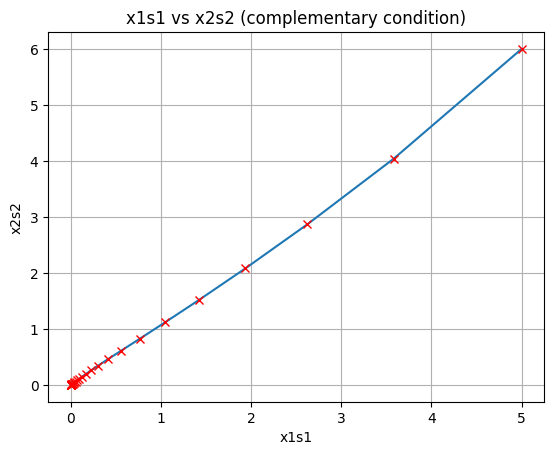

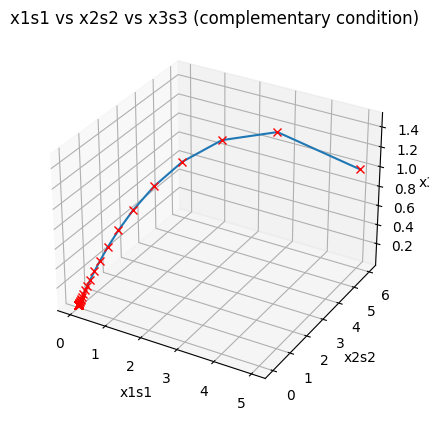

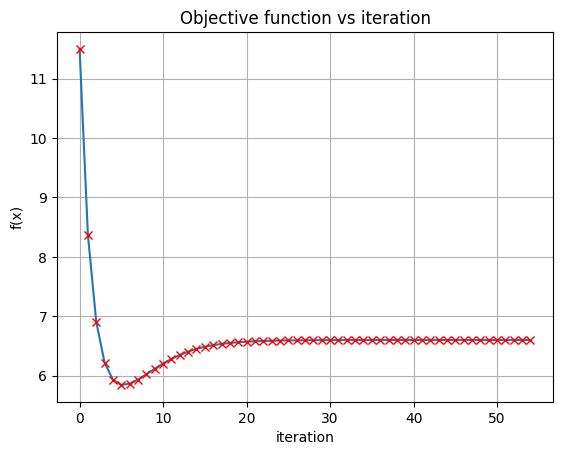

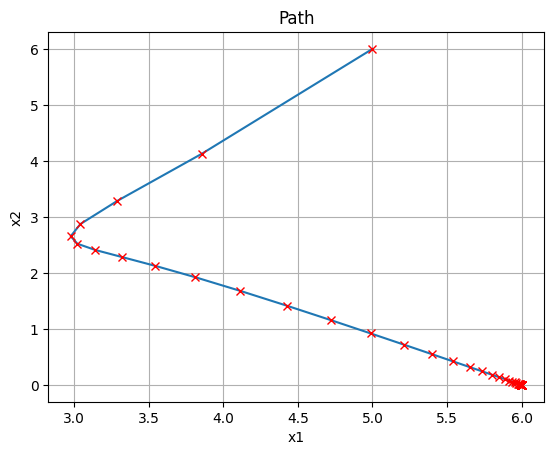

--------------------------------------------------


In [ ]:
# Initital point
x_0 = array([5,6,1])
s_0 = array([1,1,1])
y_0 = array([-1])

tol = 1e-6
alpha , sigma = 0.5, 0.5

sol = ip_central_path(
    C=C ,
    A= A ,
    B=B,
    x_0=x_0,
    y_0=y_0,
    alpha = alpha ,
    sigma= sigma ,
    tol = tol,
    s_0=s_0,
)

print_report(-C ,sol=sol)

##### Adaptive IP

--------------------------------------------------
Objective function = 
6.5999981747081184
Values for x =
[5.99999004e+00 9.12645591e-06 8.29678447e-07]
Number of iterations =
31
Plotting...


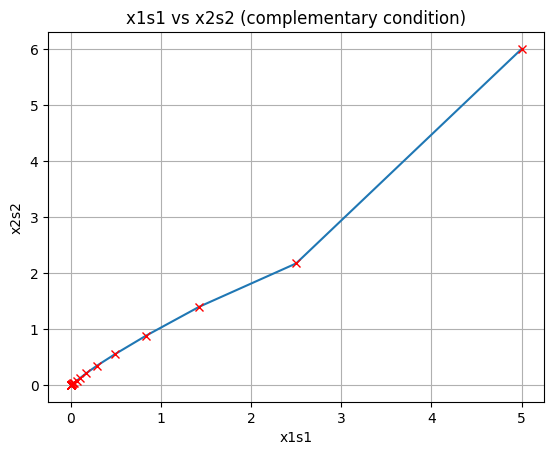

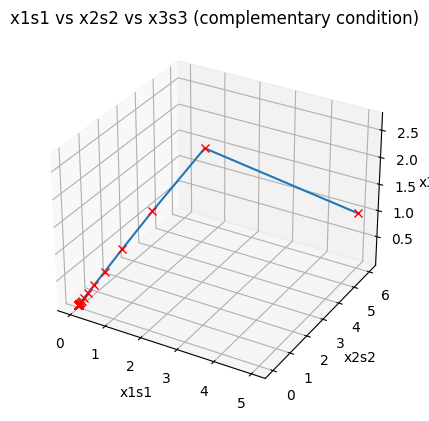

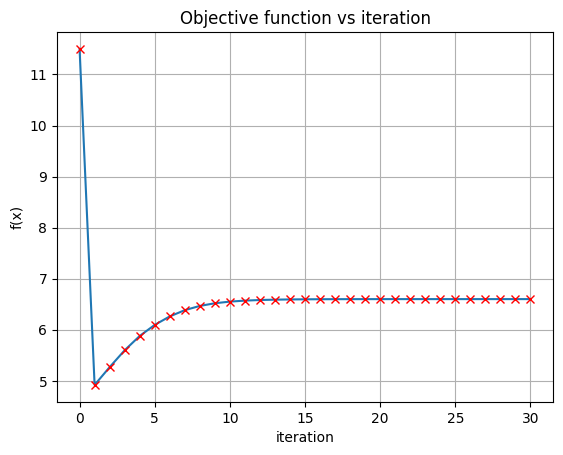

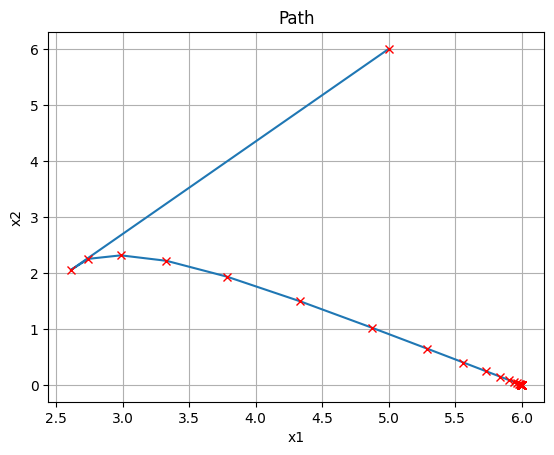

--------------------------------------------------


In [ ]:
sol = ip_central_path(
    C=C ,
    A= A ,
    B=B,
    x_0=x_0,
    y_0=y_0,
    s_0=s_0,
    alpha = "adaptive" ,
    sigma= 0.6 ,
    tol = 1e-6,
)

print_report(-C ,sol=sol)

##### IP with user defined parameters

--------------------------------------------------
Objective function = 
6.599997699718976
Values for x =
[5.99998604e+00 1.30570943e-05 1.00150150e-06]
Number of iterations =
28
Plotting...


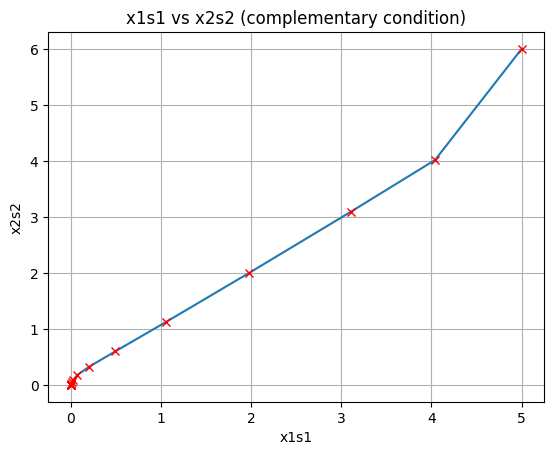

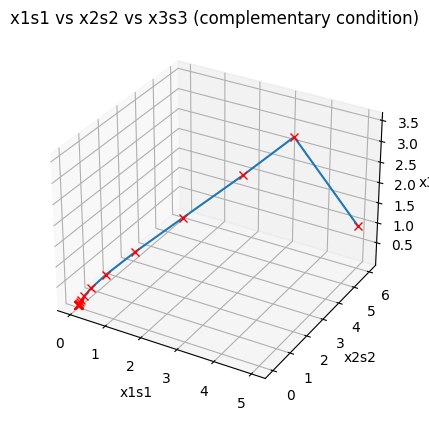

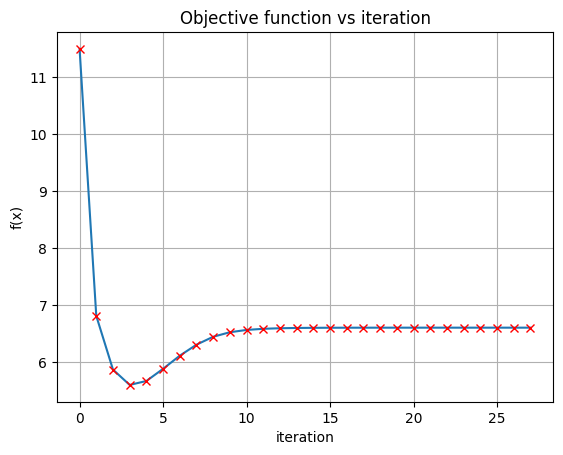

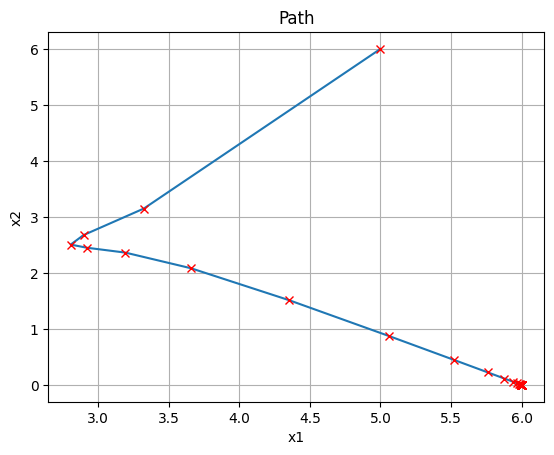

--------------------------------------------------


In [ ]:
alpha_func = lambda i :  np.exp(-i * 0.01) - 0.4   # alpha = e^(-iteration * 0.01)    - 0.4
sigma_func = lambda i: np.exp(-i * 0.5)    # sigma = e^(-iteration * 0.5)

sol = ip_central_path(
    C=C ,
    A= A ,
    B=B,
    x_0=x_0,
    y_0=y_0,
    s_0=s_0,
    alpha =  alpha_func,
    sigma= sigma_func ,
    tol = 1e-6,
)

print_report(-C ,sol=sol)

##### Mehrotra

--------------------------------------------------
Objective function = 
6.599998655990887
Values for x =
[5.99998853e+00 1.12722135e-05 1.97079787e-07]
Number of iterations =
7
Plotting...


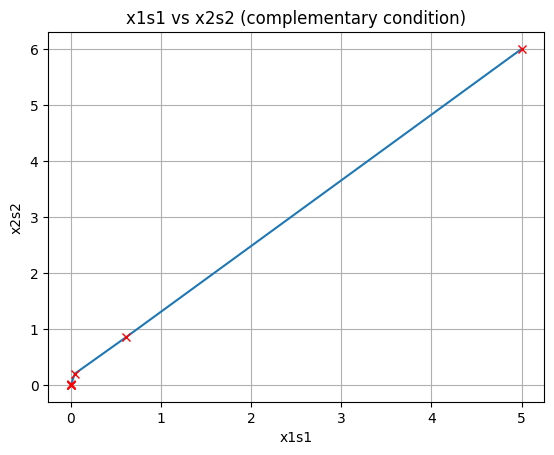

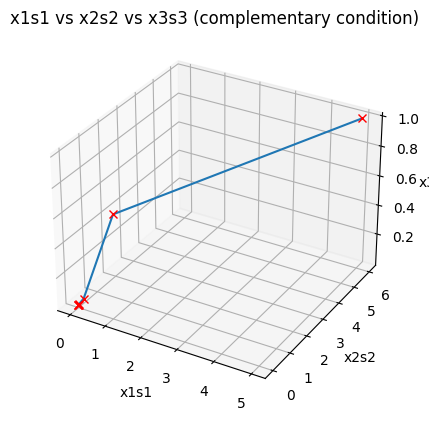

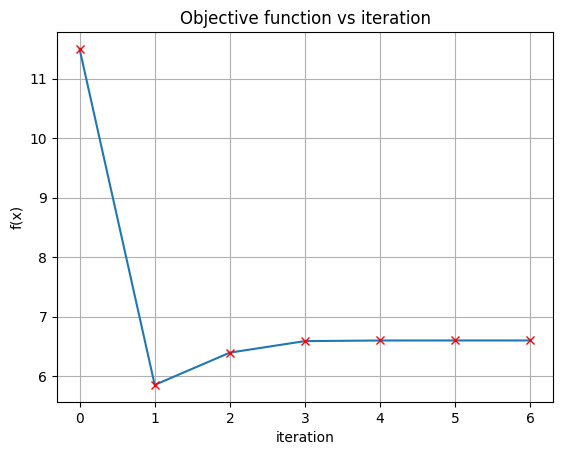

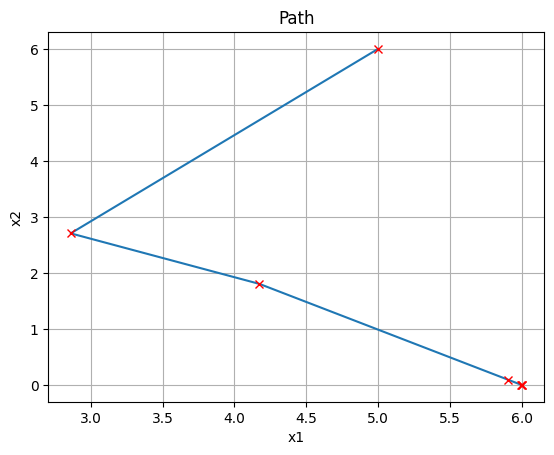

--------------------------------------------------


In [ ]:
sol = ip_mehrotra(
    C=C ,
    A= A ,
    B=B,
    x_0=x_0,
    y_0=y_0,
    s_0=s_0,
    tol = tol,
)

print_report(-C ,sol=sol)

#### Example 2
Example
$$
\begin{array}{lrl}
\text { Max } F=30 \mathrm{x}_1+20 \mathrm{x}_2 & \\
\text { s.t. } & 2 \mathrm{x}_1+\mathrm{x}_2 \leq 8 \quad \text { (Machine 1) } \\
\mathrm{x}_1+3 \mathrm{x}_2 \leq 8 \quad \text { (Machine 2) } \\
\mathrm{x}_1, \quad \mathrm{x}_2 \geq 0
\end{array}
$$

The LPP in the standard form becomes $(n=4$ and $m=2)$
$$
\begin{aligned}
& \text { Min } f=-30 \mathrm{x}_1-20 \mathrm{x}_2 \\
& \text { s.t. } 2 \mathrm{x}_1+\mathrm{x}_2+\mathrm{x}_3=8 \\
& \mathrm{x}_1+3 \mathrm{x}_2+\mathrm{x}_4=8 \\
& \mathrm{x}_1, \quad \mathrm{x}_2, \quad \mathrm{x}_3, \quad \mathrm{x}_4 \geq 0 \\
&
\end{aligned}
$$

In [ ]:
# f = −30x1 − 20x2
# 2x1 + x2 ≤ 8
# x1 + 3x2 ≤ 8

C = array([-30, -20 , 0,0])
A = array([
    [2, 1, 1,0],
    [1, 3, 0,1]
])

B = array([8,8])

##### Verification using scipy.optimize.linprog

In [ ]:
sol = linprog(C, A_eq=A, b_eq=B ,  method  = "interior-point")
sol

<ipython-input-13-76f253345546>:1: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  sol = linprog(C, A_eq=A, b_eq=B ,  method  = "interior-point")


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -127.99999964955782
       x: [ 3.200e+00  1.600e+00  1.236e-09  1.732e-08]
     nit: 4

##### Normal IP with constant parameters

--------------------------------------------------
Objective function = 
127.99999816778192
Values for x =
[3.20000005e+00 1.59999983e+00 6.54363597e-08 4.58054518e-07]
Number of iterations =
56
Plotting...


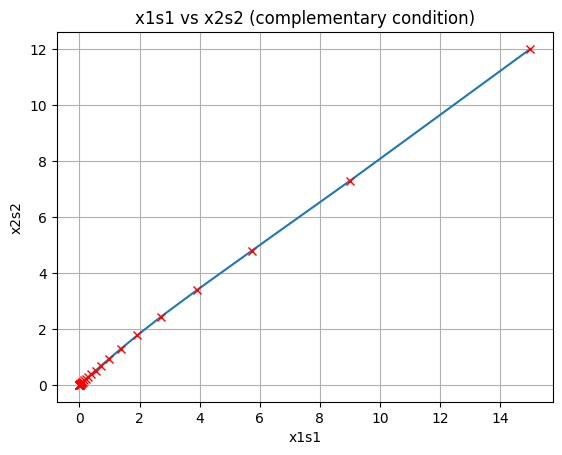

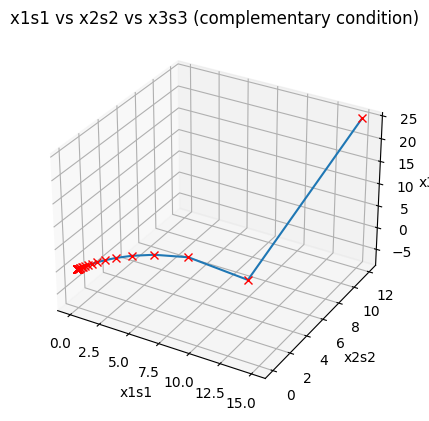

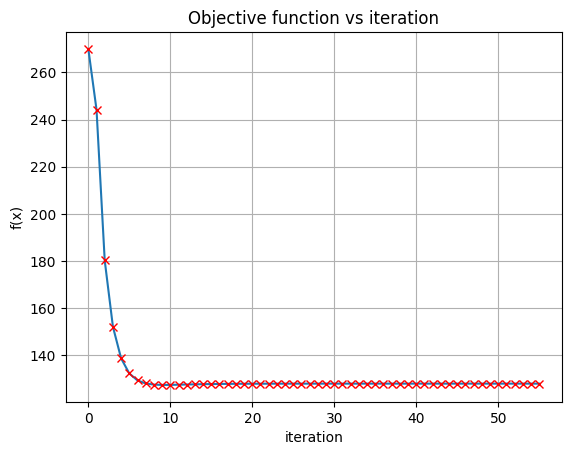

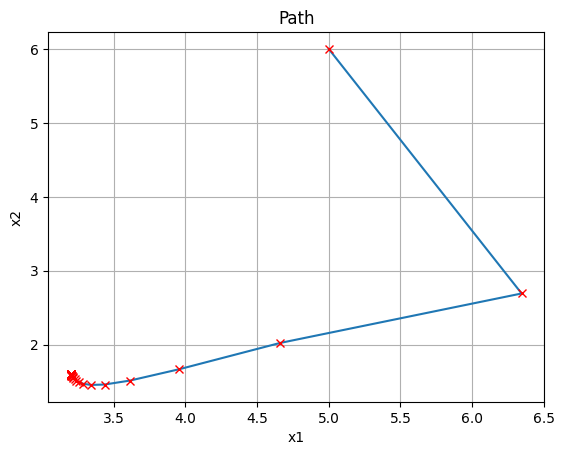

--------------------------------------------------


In [ ]:
# Initital point
x_0 = array([5,6, 5,2])
s_0 = array([3,2,5,3])
y_0 = array([2,3])

tol = 1e-6
alpha , sigma = 0.5, 0.5

sol = ip_central_path(
    C=C ,
    A= A ,
    B=B,
    x_0=x_0,
    y_0=y_0,
    alpha = alpha ,
    sigma= sigma ,
    tol = tol,
    s_0=s_0,
)

print_report(-C ,sol=sol)

##### Mehrotra

--------------------------------------------------
Objective function = 
127.99999978118875
Values for x =
[3.20000000e+00 1.59999998e+00 1.22332605e-08 5.01297530e-08]
Number of iterations =
10
Plotting...


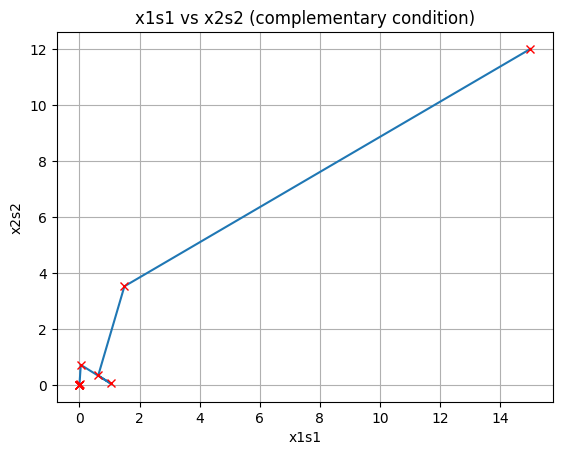

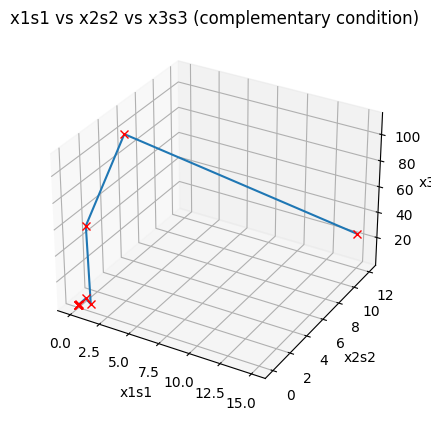

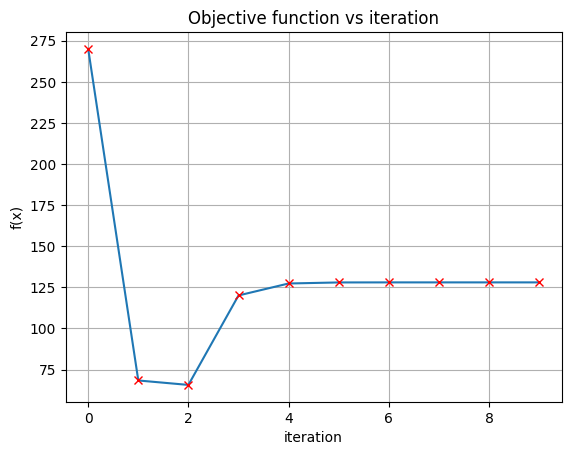

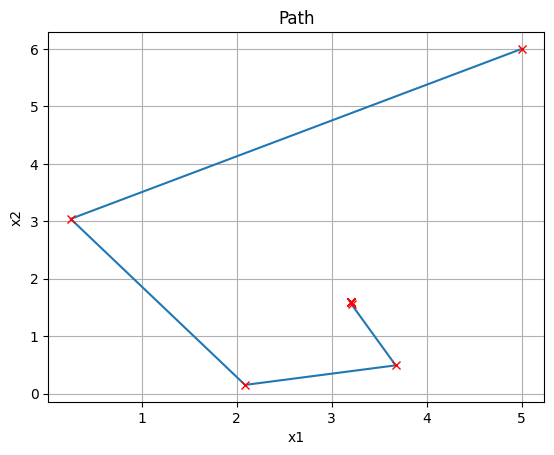

--------------------------------------------------


In [ ]:
sol = ip_mehrotra(
    C=C ,
    A= A ,
    B=B,
    x_0=x_0,
    y_0=y_0,
    s_0=s_0,
    tol = 1e-6 ,
)

print_report(-C ,sol=sol)

#### Example 3
**Objective Function:**
$$ \text{Maximize } Z = 2x_1 + x_2 $$

**Constraints:**
$$ 3x_1 + 4x_2 \leq 6 $$
$$ 6x_1 + x_2 \leq 3 $$

Using standard form
$$ 3x_1 +4x_2 +x_3 \leq 6 $$
$$ 6x_1 +x_2 +x_4 \leq 3 $$

In [ ]:
C = array([-2,-1,0,0])
A = array([
    [3,4,1,1],
    [6,1,0,1]
])

B = array([6,3])


##### Verification using scipy.optimize.linprog

In [ ]:
sol = linprog(C, A_eq=A, b_eq=B ,  method  = "interior-point")
sol

<ipython-input-17-76f253345546>:1: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  sol = linprog(C, A_eq=A, b_eq=B ,  method  = "interior-point")


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -1.8571428571485944
       x: [ 2.857e-01  1.286e+00  6.870e-14  7.043e-12]
     nit: 4

##### Normal IP with constant parameters

--------------------------------------------------
Objective function = 
1.8571410353400895
Values for x =
[2.85714210e-01 1.28571262e+00 4.78223229e-06 2.12543655e-06]
Number of iterations =
58
Plotting...


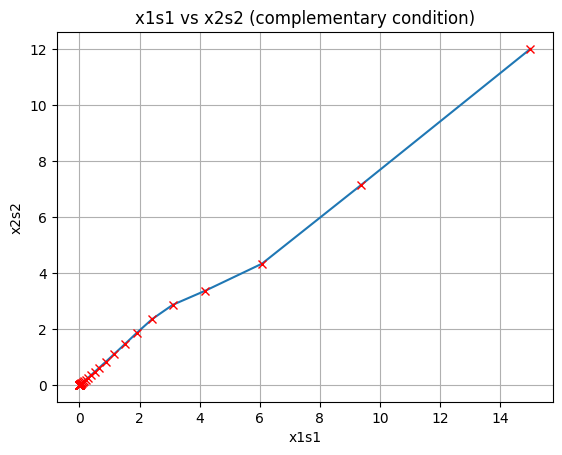

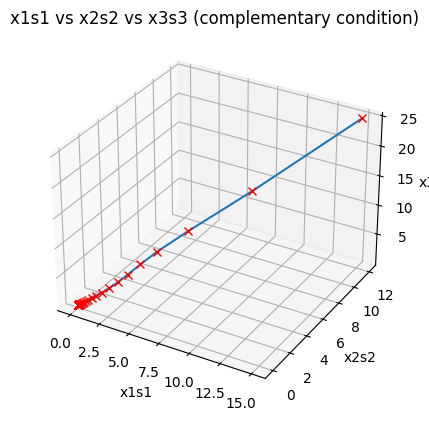

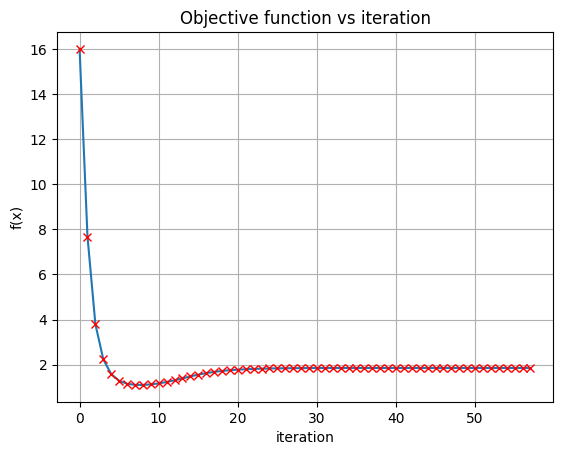

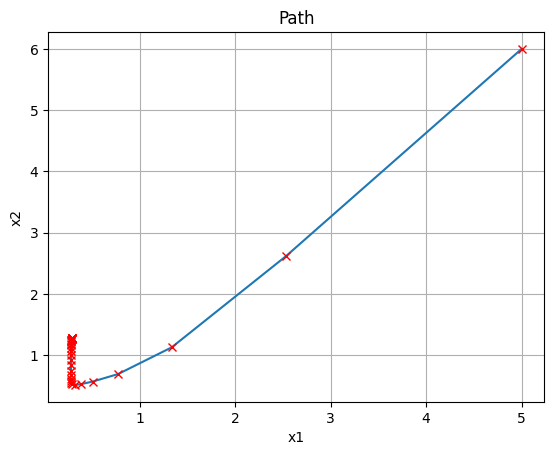

--------------------------------------------------


In [ ]:

# Initital point
x_0 = array([5,6, 5,2])
s_0 = array([3,2,5,3])
y_0 = array([2,3])

tol = 1e-6
alpha , sigma = 0.5, 0.5

sol = ip_central_path(
    C=C ,
    A= A ,
    B=B,
    x_0=x_0,
    y_0=y_0,
    alpha = alpha ,
    sigma= sigma ,
    tol = tol,
    s_0=s_0,
)

print_report(-C ,sol=sol)

##### Mehrotra

--------------------------------------------------
Objective function = 
1.8571423525897903
Values for x =
[2.85714244e-01 1.28571386e+00 1.13651460e-06 6.72172888e-07]
Number of iterations =
8
Plotting...


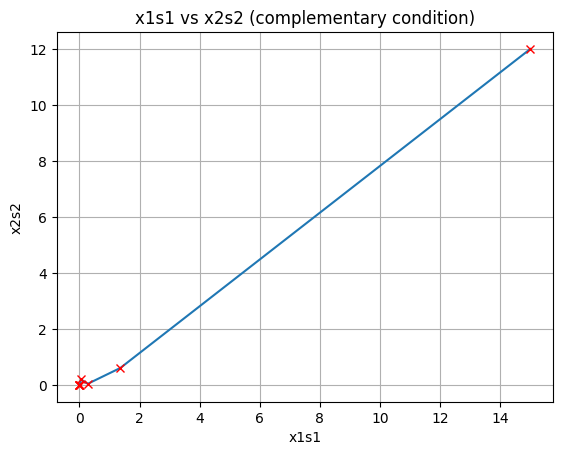

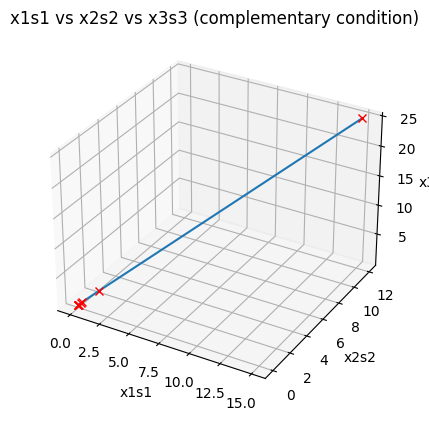

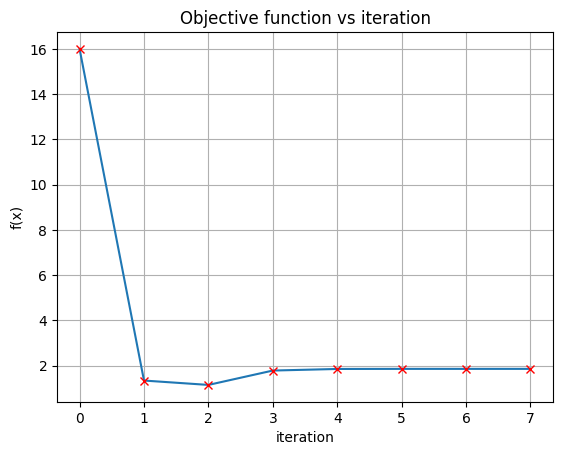

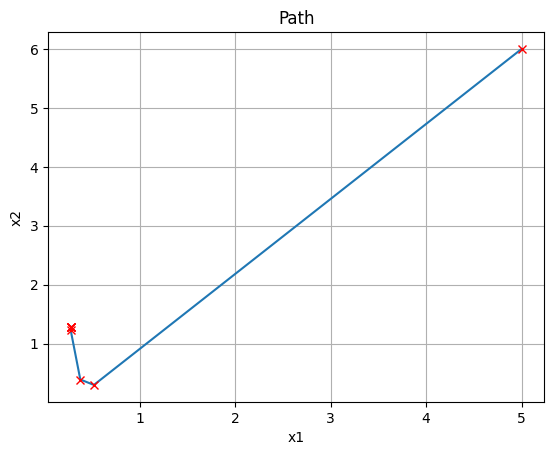

--------------------------------------------------


In [ ]:
sol = ip_mehrotra(
    C=C ,
    A= A ,
    B=B,
    x_0=x_0,
    y_0=y_0,
    s_0=s_0,
    tol = 1e-6
)

print_report(-C ,sol=sol)